[Olist Kaggle Dataset](https://www.kaggle.com/olistbr/brazilian-ecommerce?select=olist_orders_dataset.csv)

In [ ]:
# __file__ = "1.0-pr-initial-data-exploration.ipynb"
# BASE_DIR = os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
# DATA_DIR = os.path.join(os.path.join(BASE_DIR, 'data'), 'raw_data')

# files_names = [file for file in os.listdir(DATA_DIR) if file.endswith('.csv')]
# dataframes = {}
# for file_name in files_names:
#     table_name = file_name.replace("olist_", "").replace("_dataset", "").replace(".csv","")
#     dataframes[table_name] = pd.read_csv(os.path.join(DATA_DIR, file_name))
#     print(f"Loading {table_name}")    

# Business Questions. 
_We want answers!_ 

**The company's business areas have some doubts and challenges such as:**


- Can we give the same benefits to all shopkeepers (sellers)? Or is there one that deserves to be highlighted?


- Is there a difference in the amount of freight charged in different regions, cities? Or can we apply the shipping subsidy rules to any location?


- Is our product catalog comprehensive? Or does it focus on specific categories?


- Do we always sell the same products? Or are there seasonalities?



**Dashboard that analyzes the company's latest sales data that can be shared with Regional leads and their respective analysts:**

- Total Sales
- Sales per Region
- Top 5 selling categories for each Region



**We also need to know:**

> Number of Orders Per Day.
>
> Number of Orders per city.
>
> Number of Orders by Payment Method.

- What is the revenue for each product category? What about total sales, in units and in orders?
- What is the total amount of revenue generated by customers in each state? 
- What is the total amount of revenue generated by sellers in each state?

_delivered orders only_

# 0.0 Imports

In [1]:
import psycopg2

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import date

import dotenv
import os
from IPython.display import Image

In [35]:
# Settings
dotenv.load_dotenv(dotenv.find_dotenv(os.path.expanduser("-")))

__file__ = "1.0-pr-data-analysis-postgresql.ipynb"
THIS_DIR = os.path.dirname(os.path.dirname(os.path.abspath(__file__)))
BASE_DIR = os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
DATA_DIR = os.path.join(os.path.join(BASE_DIR, 'data'))
DASHBOARD_DATA_DIR = os.path.join(DATA_DIR, "business_questions_insights_dashboard_data")

## 0.1 Helper Classes

In [9]:
class QueryBuilder:
    def __init__(self):
        self.select_value = ''
        self.from_table_name = ''
        self.where_value = ''
        self.groupby_value = ''
        self.limit_value = ''
        self.having_value = ''
        self.last_query_value = ''

    def select(self, select_arg):
        self.select_value = select_arg
        return self

    def from_table(self, from_arg):
        self.from_table_name = from_arg
        return self

    def where(self, where_arg):
        self.where_value = where_arg
        return self

    def groupby(self, groupby_args):
        self.groupby_value = groupby_args
        return self
    
    def having(self, having_value):
        self.having_value = having_value
    
    def limit(self, limit_args):
        self.limit_value = limit_args
        return self
    
    def reset(self):
        self.select_value = ''
        self.from_table_name = ''
        self.where_value = ''
        self.groupby_value = ''
        self.limit_value = ''
        self.having_value = ''
        return self
    
    def last_query(self):
        return self.last_query_value

    def build(self, reset=True):
        where_clause = ''
        groupby_clause = ''
        having_clause =''
        limit_clause = ''
        
        if self.where_value:
            where_clause = f'WHERE  {self.where_value}'
        if self.groupby_value:
            groupby_clause = f'GROUP BY {self.groupby_value}'
        if self.limit_value:
            limit_clause = f'LIMIT {self.limit_value}'
        if self.having_value:
            having_clause = f'HAVING {self.having_value}'

        self.last_query_value = f"""
           SELECT {self.select_value}
           FROM   {self.from_table_name}
           {where_clause}
           {groupby_clause}
           {having_clause}
           {limit_clause};
        """
        
        if reset:
            self.reset()
        
        return self.last_query_value
    
    
class PostegreSQL:
    def __init__(self, host="localhost", user="postgres", password="********", database="postgres"):
        self.conn = psycopg2.connect(host=host, user=user, password=password, database=database)
        self.cursor = self.conn.cursor()
        
    def execute(self, query):
        self.cursor.execute(query)
        return [table for table in self.cursor.fetchall()]
    
    def columns(self, table_name):
        self.cursor.execute(F"""SELECT column_name FROM information_schema.columns WHERE table_name = '{table_name}'""" )
        return [table[0] for table in self.cursor.fetchall()]
    
    def tables(self):
        self.cursor.execute("""SELECT table_name FROM information_schema.tables WHERE table_schema = 'public'""")
        return [table for table in self.cursor.fetchall()]
    
    def rollback(self):
        self.cursor.execute("ROLLBACK;")

## 0.2  Helper Functions

In [11]:
def db_mer_schema():
    return Image( '../images/mer.png' ) 


def to_pandas(query_result, columns):
    return pd.DataFrame(query_result, columns=columns)
    
    
def write_query(file_name, query):
    with open(f'{file_name}.sql', 'w') as file:
        file.write(query)

def read_query(path):      
    with open(f'{path}', 'r') as file:
        return file.read()
    

def fig(x=15, y=5):
    plt.figure(figsize=(x,y))

## 0.3 Loading Data

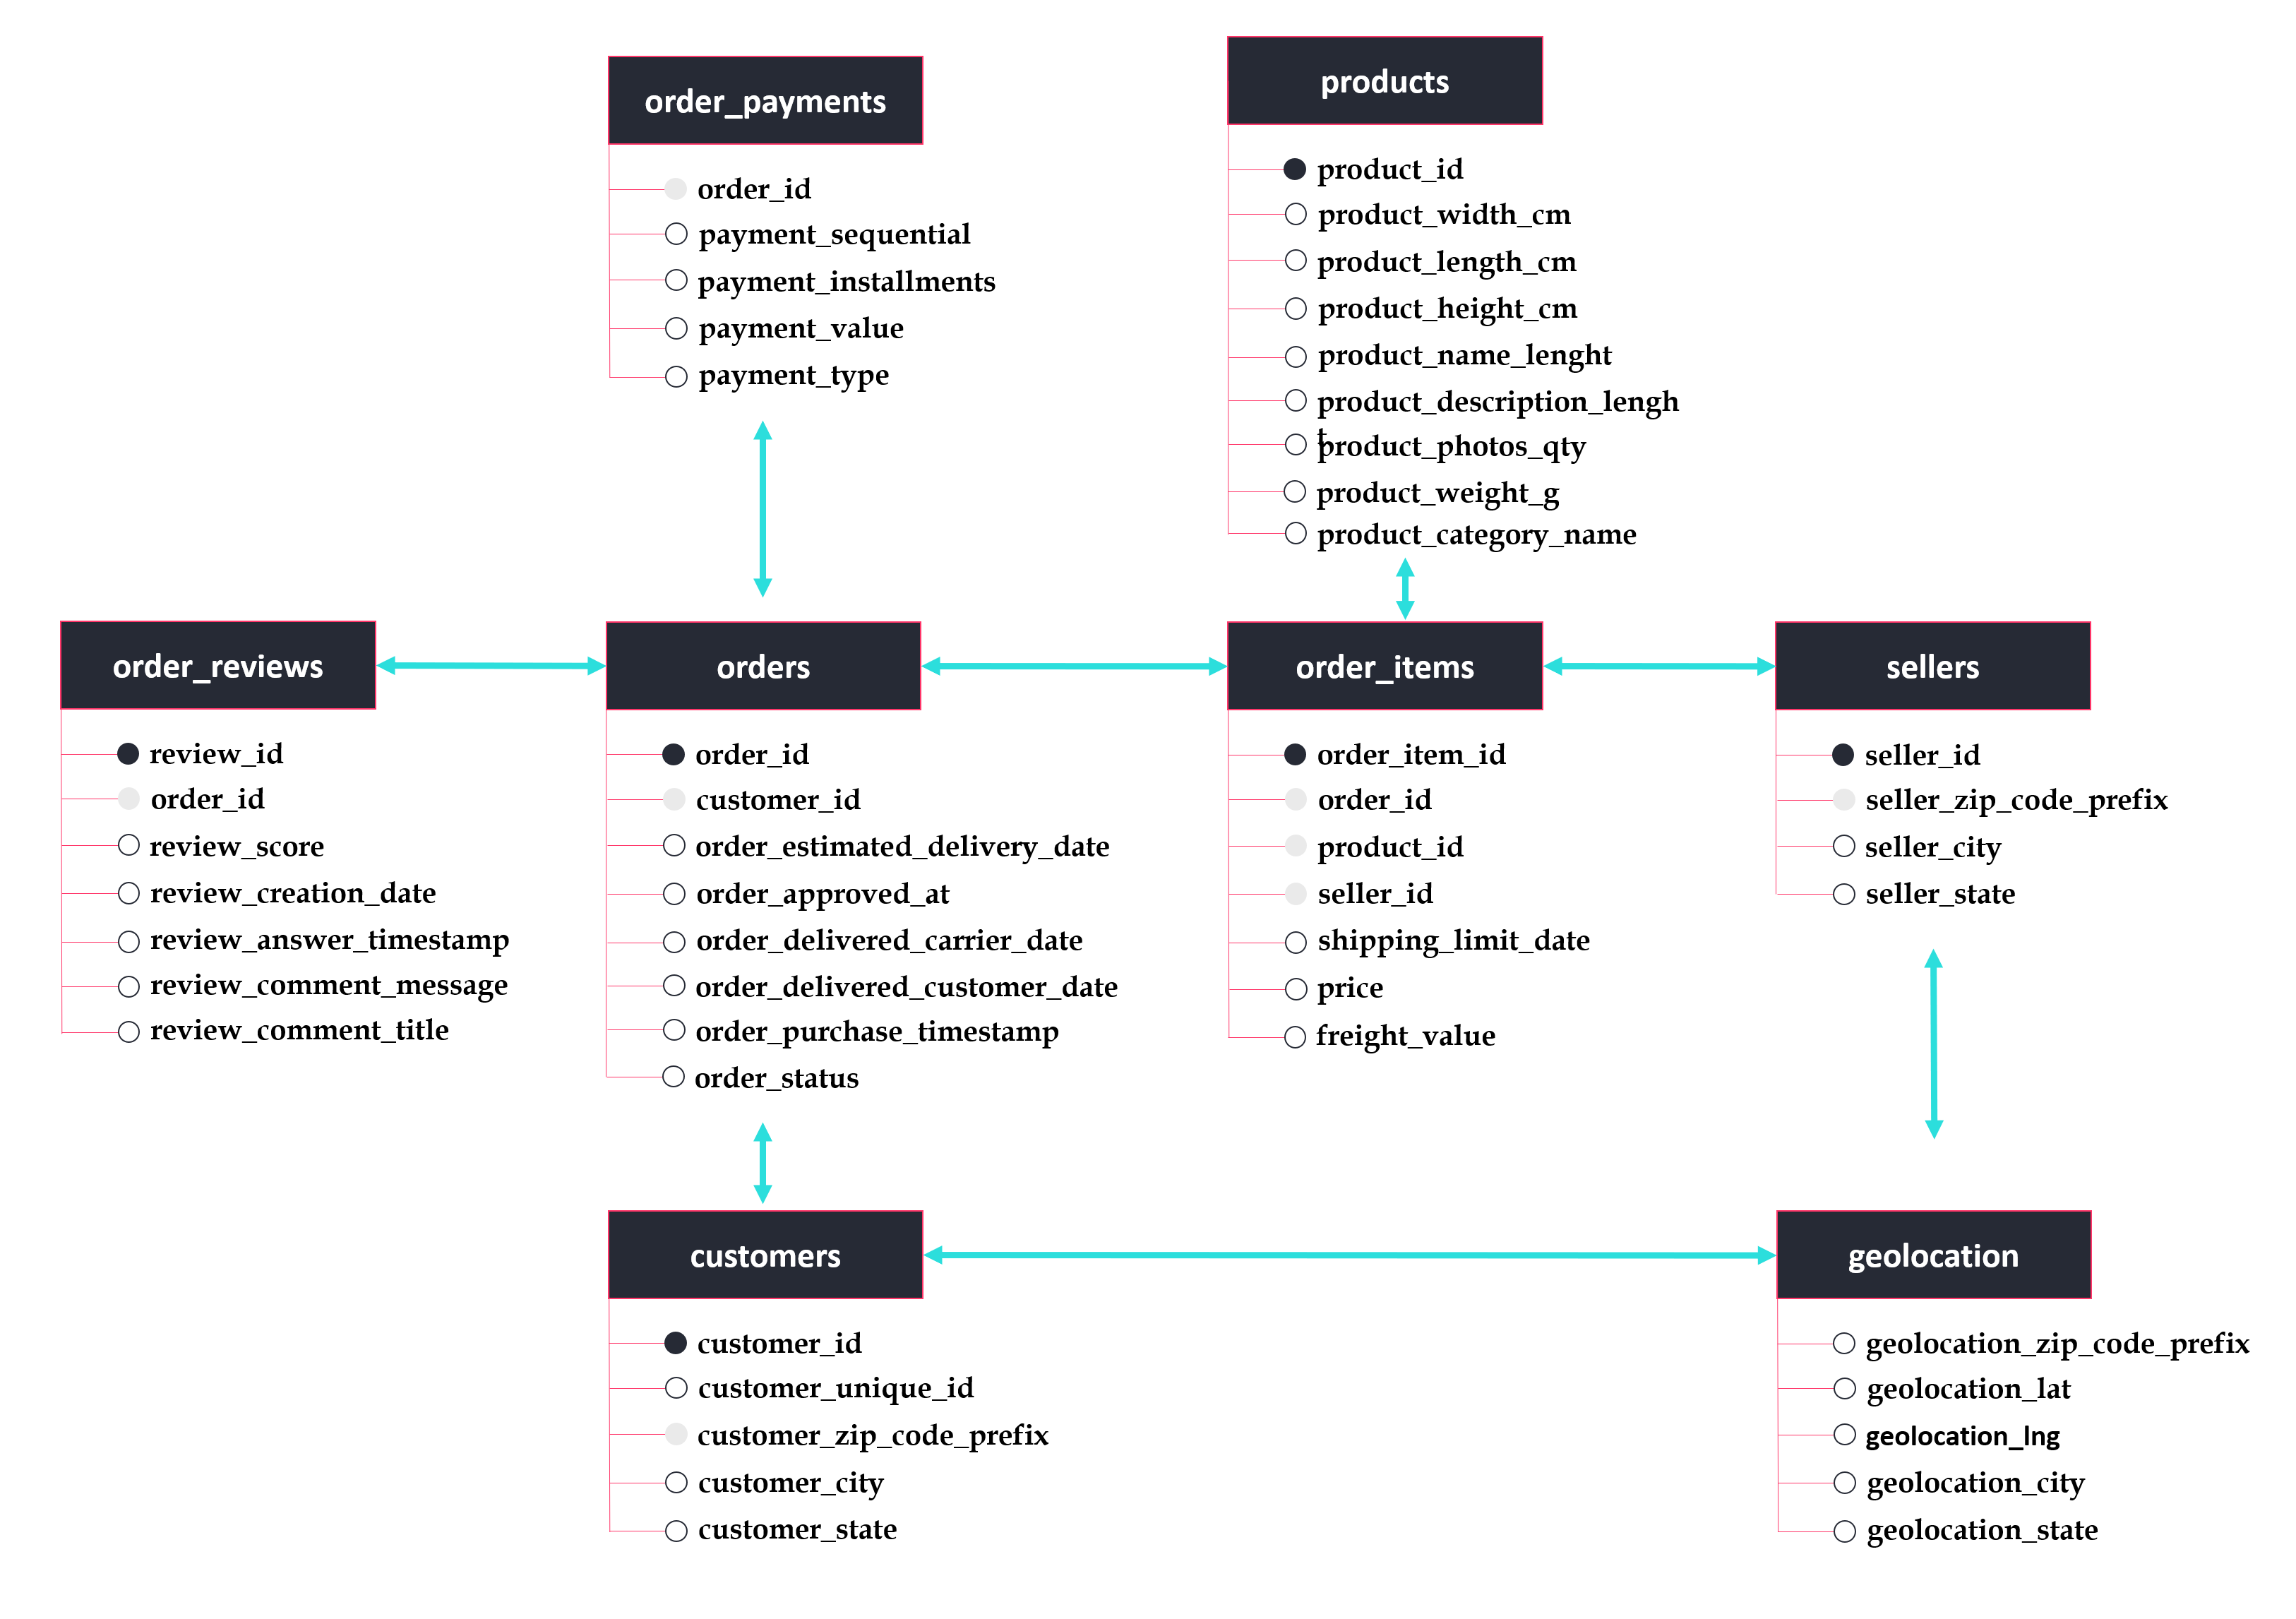

In [6]:
db_mer_schema()

<font  color='grey'>
    As my service was in stopped state somehow. "On windows, Just go to the 'Services'. Start/Restart the postgresql-X64 service".<br>
<a href='https://stackoverflow.com/questions/40532399/unable-to-connect-to-server-for-postgres' target='_blank'>stackoverflow</a>
</font>

In [12]:
db = PostegreSQL(host="localhost", user="postgres", password=os.getenv("POSTGRES_PASSWORD"), database="postgres")

In [13]:
db.tables()

[('order_items',),
 ('products',),
 ('sellers',),
 ('orders',),
 ('order_reviews',),
 ('order_payments',),
 ('geolocation',),
 ('customers',)]

## 1.0 Dashboard Queries

In [14]:
query = QueryBuilder()

### 1.1 Total Sales

_from confirmed (delivered) orders_

In [50]:
# q = query.select("date(MIN(order_purchase_timestamp)), SUM(price)").\
#          from_table("orders LEFT JOIN order_items ON orders.order_id = order_items.order_id").\
#          where('''order_status='delivered' and
#                   order_purchase_timestamp BETWEEN date('{intial_date}') AND date('{final_date}')''').\
#          build()

# print(q.format(intial_date='2016-09-04', final_date='2018-10-17'))

# write_query("../sql_queries/total_sales_per_month", q)

In [15]:
query.select("MIN(order_purchase_timestamp), MAX(order_purchase_timestamp)").from_table("orders")
to_pandas(db.execute(query.build()),['first_purchase','last_purchase'])

,first_purchase,last_purchase
0,2016-09-04 21:15:19,2018-10-17 17:30:18


In [19]:
def get_annual_sales(year):
    sales_per_month = pd.DataFrame()
    for month in range(1, 13):

        intial_date = str(date(year, month, 1))
        if month == 12:
            month = 0
            year += 1
        final_date = str(date(year, month+1, 1))
        total_sales_query = query.select("date(MIN(order_purchase_timestamp)), SUM(price)").\
                            from_table("orders LEFT JOIN order_items ON orders.order_id = order_items.order_id").\
                            where(f'''order_status='delivered' and 
                                  order_purchase_timestamp BETWEEN date('{intial_date}') AND date('{final_date}')''').\
                            build()

        sales_per_month = pd.concat([sales_per_month,to_pandas(db.execute(total_sales_query),['date','total_sales'])], axis=0)
        sales_per_month['date'] = pd.to_datetime(sales_per_month['date'])
        sales_per_month['month'] = sales_per_month['date'].dt.strftime('%b')
        
    return sales_per_month.reset_index(drop=True)

get_annual_sales(2017)

,date,total_sales,month
0,2017-01-05,111798.36,Jan
1,2017-02-01,234223.40,Feb
2,2017-03-01,359198.85,Mar
3,2017-04-01,340669.68,Apr
4,2017-05-01,489338.25,May
5,2017-06-01,421923.37,Jun
6,2017-07-01,481604.52,Jul
7,2017-08-01,554699.70,Aug
8,2017-09-01,607399.67,Sep
9,2017-10-01,648247.65,Oct


In [20]:
year = 2018
annual_sales = get_annual_sales(year).dropna()

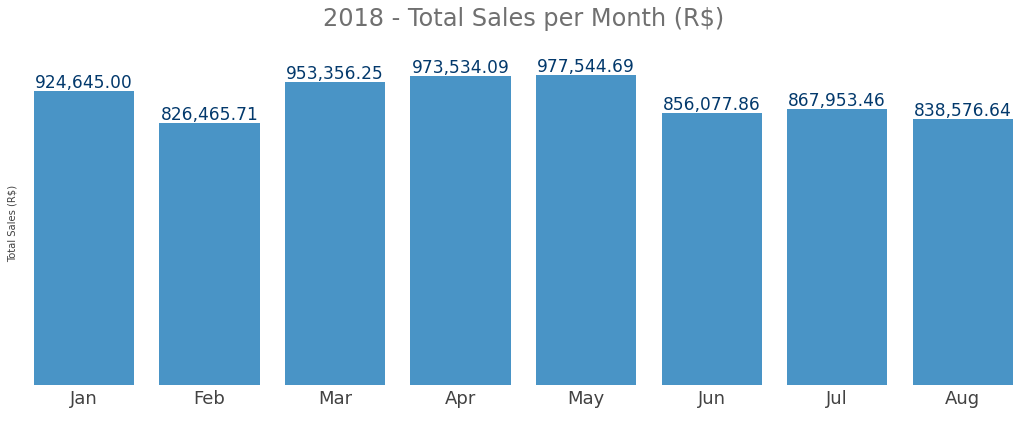

In [21]:
x = list(range(len(annual_sales['month'])))
sales = annual_sales['total_sales'].values
fig(18,6)
sns.barplot(data=annual_sales, x='month', y='total_sales', color='#3498db');

plt.box(False)
plt.title(f"{year} - Total Sales per Month (R$)\n", fontsize=24, color='#707070')
plt.tick_params(axis='both', which='both', length=0)
plt.xlabel(" ", color='#424242')
plt.ylabel("Total Sales (R$)", color='#424242')
plt.xticks(color="#424242", size=18)
plt.yticks([],[])

for sale_value in range(len(sales)):
    plt.annotate("{:,.2f}".format(sales[sale_value]), xy=(x[sale_value],sales[sale_value]),
                 ha='center', va='bottom', size=17, color='#03396c')
plt.show()

In [38]:
annual_sales.to_csv(os.path.join(DASHBOARD_DATA_DIR, "monthly_sales_2018.csv"))

### 1.2 Sales per Region

In [39]:
def get_annual_sales(year):
    sales_per_month = pd.DataFrame()
    for month in range(1, 13):

        intial_date = str(date(year, month, 1))
        if month == 12:
            month = 0
            year += 1
        final_date = str(date(year, month+1, 1))
        total_sales_query = query.select("date(MIN(order_purchase_timestamp)), SUM(price), customer_state").\
                            from_table('''orders LEFT JOIN order_items ON orders.order_id = order_items.order_id
                                         LEFT JOIN customers ON orders.customer_id = customers.customer_id''').\
                            where(f'''order_status='delivered' and 
                                  order_purchase_timestamp BETWEEN date('{intial_date}') AND date('{final_date}')''').\
                            groupby("customers.customer_state").\
                            build()

        sales_per_month = pd.concat([sales_per_month,to_pandas(db.execute(total_sales_query),['date','total_sales','state'])], axis=0)
        sales_per_month['date'] = pd.to_datetime(sales_per_month['date'])
        sales_per_month['month'] = sales_per_month['date'].dt.strftime('%b')
        
    return sales_per_month.reset_index(drop=True)

get_annual_sales(2017).head(2)

,date,total_sales,state,month
0,2017-01-21,589.60,AC,Jan
1,2017-01-25,393.97,AL,Jan


In [40]:
region_sales_per_month = get_annual_sales(2018)

In [41]:
def map_regions(state):
    regions = {
        'north': ['AM','RR','AP','PA','TO','RO','AC'],
        'northeast': ['MA','PI','CE','RN','PE','PB','SE','AL','BA'],
        'midwest': ['MT','MS','GO','DF'],
        'southeast': ['SP','RJ','ES','MG'],
        'south': ['PR','RS','SC']
    }
    for region, states in regions.items():
        if state in states:
            return region

In [105]:
region_sales_per_month['region'] = region_sales_per_month.state.apply(map_regions)

In [141]:
region_sales_per_month.groupby("region").agg(['sum','mean','median']).round(2)

total_sales                      
                  sum       mean     median
region                                     
midwest     451261.13   14101.91   13309.95
north       161528.92    2936.89    1811.80
northeast   785140.40   10904.73    6866.88
south      1033757.65   43073.24   44046.22
southeast  4786465.60  149577.05  108298.86

In [ ]:
# index.get_level_values("second")

In [172]:
region_sales_per_month.groupby(['region','month']).sum().loc[['midwest']]

total_sales
region  month             
midwest Apr       54255.80
        Aug       48081.26
        Feb       55613.59
        Jan       54785.43
        Jul       60599.21
        Jun       52827.42
        Mar       53825.66
        May       71272.76

### 1.3 Top 5 selling categories for each Region

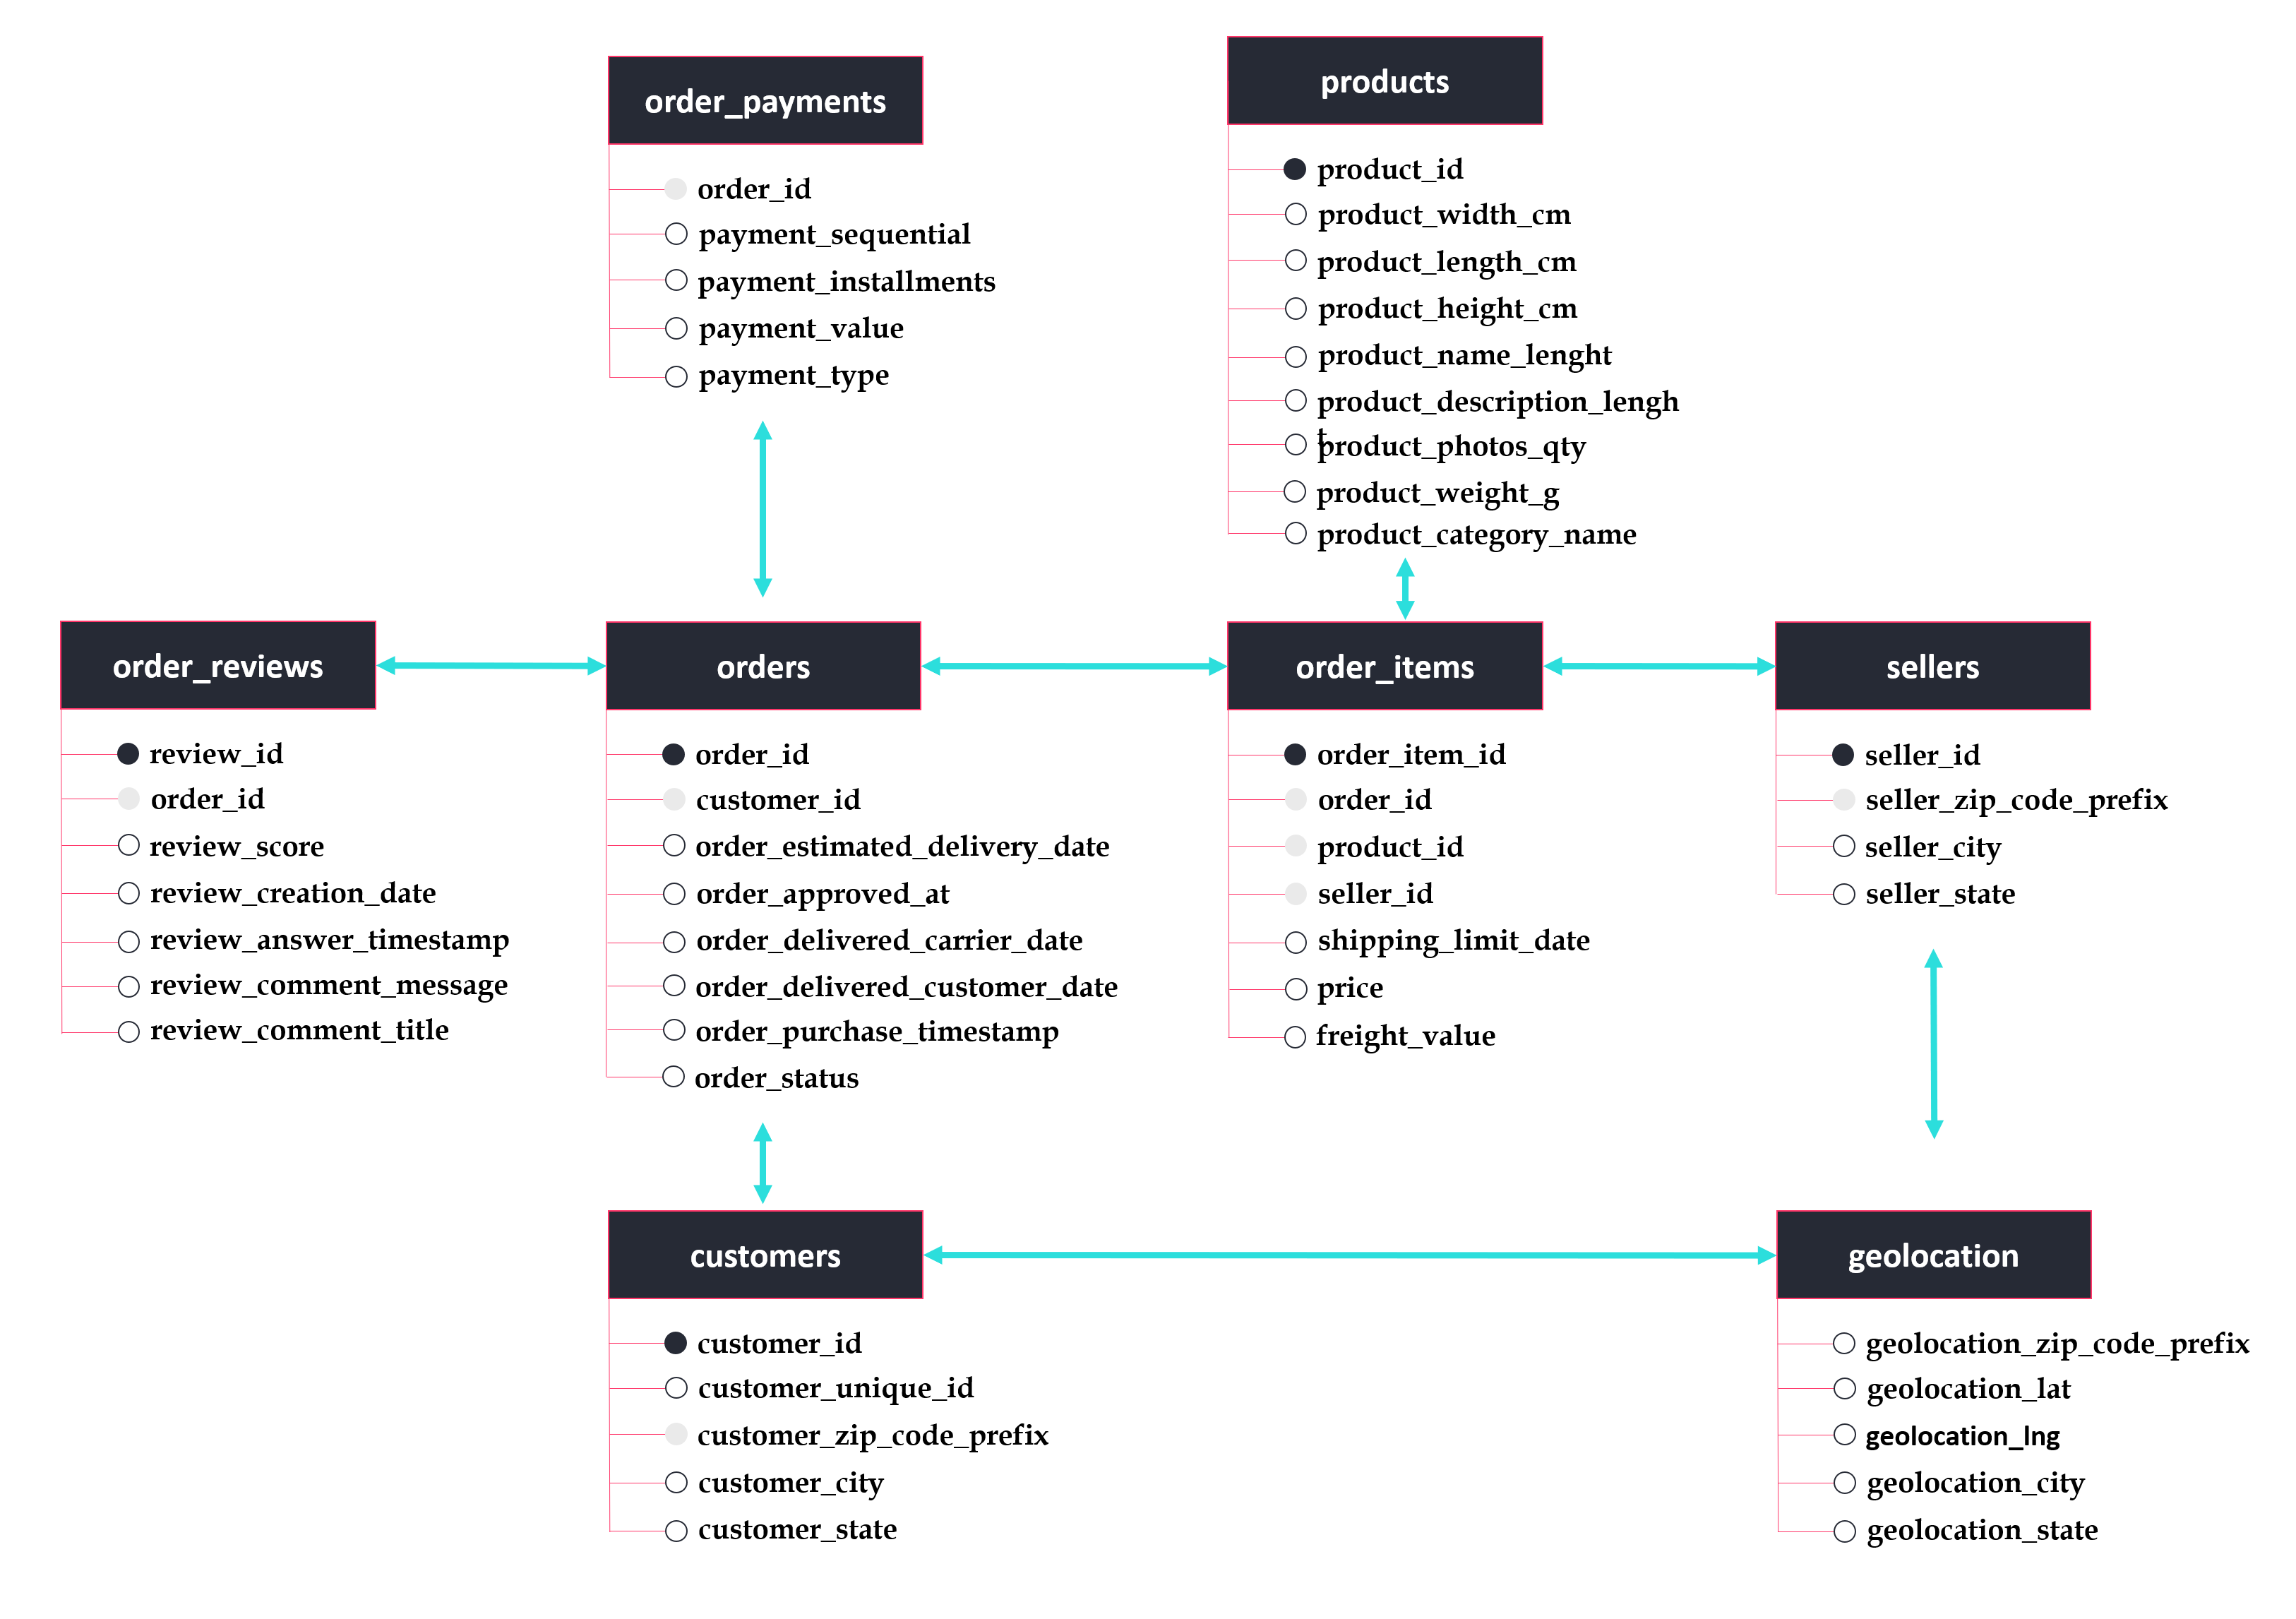

In [199]:
db_mer_schema()

In [217]:
intial_date = "2018-08-01"
final_date  = "2018-09-01"

In [218]:
sales_per_category_query = query.select("product_category_name, price, customer_state").\
                                 from_table('''orders LEFT JOIN order_items ON orders.order_id = order_items.order_id
                                               LEFT JOIN products ON products.product_id = order_items.product_id
                                               LEFT JOIN customers ON orders.customer_id = customers.customer_id''').\
                                 where(f"order_purchase_timestamp BETWEEN date('{intial_date}') AND date('{final_date}')").\
                                 build()
sales_per_category = to_pandas(db.execute(sales_per_category_query),['category','total_sales','state'])

In [219]:
sales_per_category['region'] = sales_per_category.state.apply(map_regions)

In [233]:
sales_per_category.groupby(["region", "category"]).sum().loc[['midwest']].sort_values(by=['total_sales'], ascending=False)\
.head(5)

total_sales
region  category                           
midwest beleza_saude                9829.87
        relogios_presentes          5963.73
        utilidades_domesticas       3462.29
        ferramentas_jardim          3331.51
        informatica_acessorios      2477.15

# AQUI AQUI AQUI AQUI AQUI AQUI AQUI AQUI AQUI AQUI AQUI AQUI AQUI AQUI AQUIV AQUI AQUI AQUI AQUI AQUI AQUIV AQUI AQUI AQUI AQUI AQUI AQUI AQUI AQUI AQUI AQUI AQUI AQUI AQUI AQUI AQUI

### 1.4 Number of Orders Per Day.

In [20]:
db.columns("orders")

['order_estimated_delivery_date',
 'order_approved_at',
 'order_delivered_carrier_date',
 'order_delivered_customer_date',
 'order_purchase_timestamp',
 'customer_id',
 'order_status',
 'order_id']

In [238]:
orders_per_day_query = query.select("order_approved_at::DATE as time, COUNT(order_id) as orders").from_table("orders").\
                       groupby("time").build()
orders_per_day_table = db.execute(orders_per_day_query)

In [239]:
orders_per_day = pd.DataFrame(orders_per_day_table, columns=['date','total_orders'])
orders_per_day.date = pd.to_datetime(orders_per_day.date)

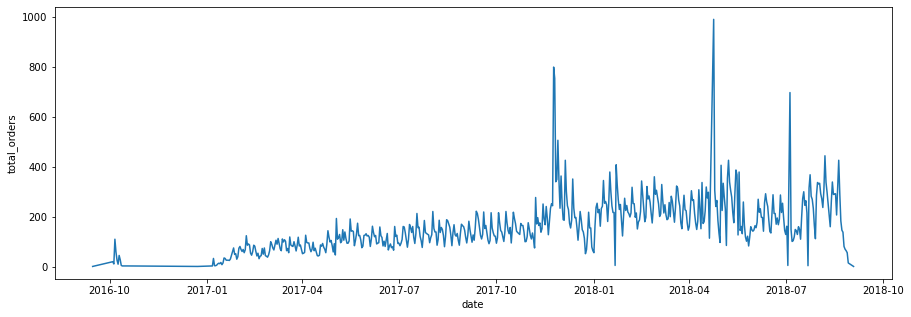

In [240]:
fig()
sns.lineplot(data=orders_per_day, x='date', y='total_orders');

### 1.5 Number of Orders per city.

In [213]:
orders_by_state_query = query.select("customer_state, COUNT(order_id)").\
                              from_table("orders LEFT JOIN customers ON orders.customer_id = customers.customer_id").\
                              groupby("customer_state").build()
orders_by_state_table = db.execute(orders_by_state_query)

In [214]:
orders_by_state = pd.DataFrame(orders_by_state_table, columns=['state','total_orders'])

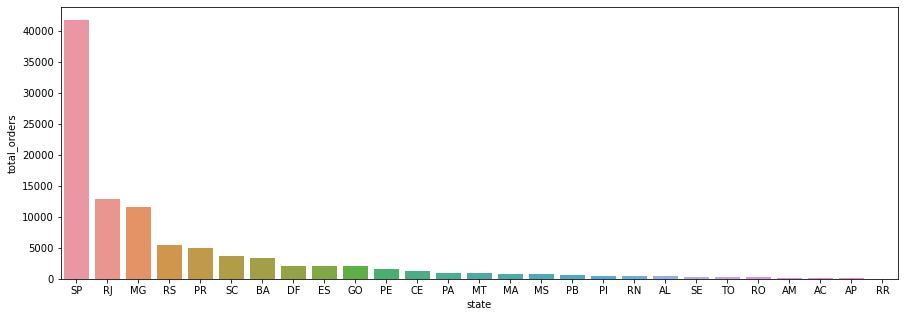

In [233]:
fig()
sns.barplot(data=orders_by_state.sort_values("total_orders", ascending=False), x='state', y='total_orders');

### 1.6 Number of Orders by Payment Method.

In [247]:
orders_by_payment_query = query.select("payment_type, COUNT(orders.order_id)").\
                                from_table("orders LEFT JOIN order_payments ON orders.order_id = order_payments.order_id").\
                                groupby("payment_type").build()
orders_by_payment_table = db.execute(orders_by_payment_query)

In [248]:
orders_by_payment = pd.DataFrame(orders_by_payment_table, columns=['payment_method','total_orders'])

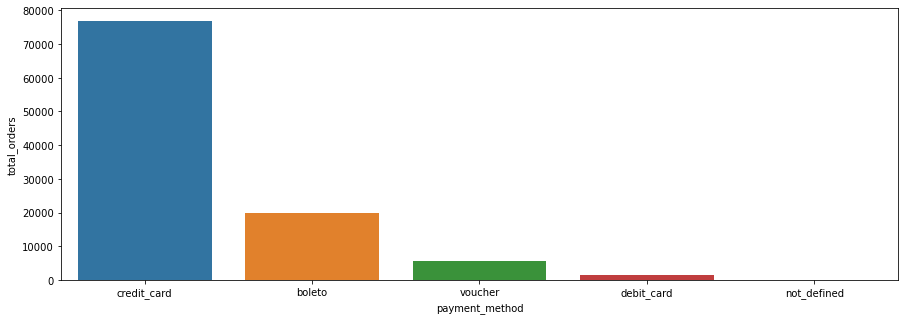

In [255]:
fig()
sns.barplot(data=orders_by_payment.sort_values("total_orders", ascending=False), x='payment_method', y='total_orders');

### 1.7 What is the revenue for each product category? What about total sales, in units and in orders?

ps: _delivered orders only_

In [9]:
print( db.execute("SELECT DISTINCT(order_status) FROM orders") )

[('shipped',), ('unavailable',), ('invoiced',), ('created',), ('approved',), ('processing',), ('delivered',), ('canceled',)]


In [12]:
tables_join = '''orders LEFT JOIN customers ON orders.customer_id = customers.customer_id
                        LEFT JOIN order_items ON orders.order_id = order_items.order_id'''
revenue_by_state_query = query.select("customer_state, COUNT(orders.order_id), SUM(price), AVG(price)")\
                              .from_table(tables_join)\
                              .where("order_status = 'delivered'").groupby("customer_state").build()
revenue_by_state_table = db.execute(revenue_by_state_query)

In [15]:
revenue_by_state = pd.DataFrame(revenue_by_state_table, columns=['state','total_orders','total_revenue','mean_revenue'])

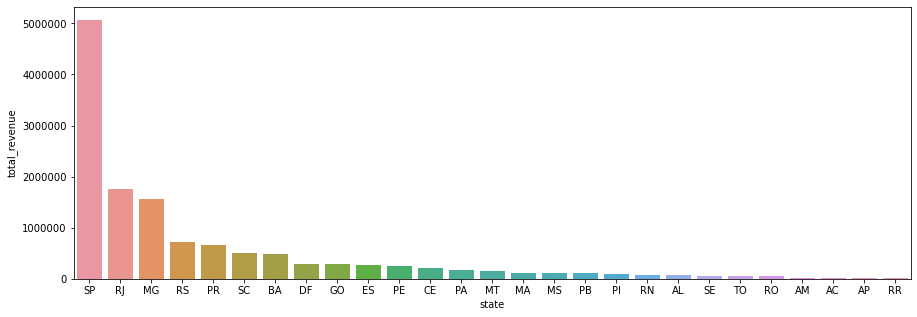

In [31]:
fig()
sns.barplot(data=revenue_by_state.sort_values("total_revenue", ascending=False), x='state', y='total_revenue');
plt.ticklabel_format(style='plain', axis='y')

### 1.8 What is the total amount of revenue generated by customers in each state?

ps: _delivered orders only_

### 1.9 What is the total amount of revenue generated by sellers in each state?

ps: _delivered orders only_

## 2.0 Business Challenges

In [ ]:
locations = pd.DataFrame(db.execute("SELECT geolocation_state, geolocation_lat, geolocation_lng FROM geolocation;"),
                         columns=['state','lat','lng'])
locations['region'] = locations.state.apply(map_regions)

fig(15, 10)
sns.scatterplot(data=locations, x='lng', y='lat', hue='region')
plt.xlim(-75, -30)
plt.ylim(-40, 10);